# Laplace's equation

In [1]:
# Import libraries.
from matplotlib import pyplot, cm
from mpl_toolkits import mplot3d
import numpy as np

%matplotlib inline

In [2]:
# Change default font family and size for Matplotlib figures.
pyplot.rc('font', family='serif', size=16)

## Problem setup

Solve the Laplace's equation $\nabla^2 u = 0$ in the domain $\Omega = \left[ 0, L_x \right] \times \left[ 0, L_y \right]$

<img src="figures/application_setup.png" alt="application_setup" width="300"/>

Initial guess: $u = 0$ everywhere inside the domain.

## Analytical solution

$$
u \left( x, y \right) = \frac{\sinh \left( \frac{3}{2} \pi \frac{y}{L_y} \right)}{\sinh \left( \frac{3}{2} \pi \frac{L_x}{L_y} \right)} \sin \left( \frac{3}{2} \pi \frac{x}{L_x} \right)
$$

In [3]:
def laplace_solution(x, y, Lx, Ly):
    """Return the analytical solution.

    Parameters
    ----------
    x : numpy.ndarray
        Coordinates along the x direction as a 1D array of floats.
    y : numpy.ndarray
        Coordinates along the y direction as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.

    Returns
    -------
    u : numpy.ndarray
        The analytical solution as a 2D array of floats.

    """
    nx = x.shape[0]
    ny = y.shape[0]
    u = np.empty((ny, nx))
    for i in range(nx):
        for j in range(ny):
            num = np.sinh(1.5 * np.pi * y[j] / Ly)
            den = np.sinh(1.5 * np.pi * Lx / Ly)
    
            u[j, i] = num / den * np.sin(1.5 * np.pi * x[i] / Lx)
    
    
    
    return u

In [4]:
def plot_3d(x, y, u, label='$z$', elev=30.0, azim=45.0):
    """Create a 3D surface plot of the scalar field `u`.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    u : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction; default: 'z'.
    elev : float, optional
        Elevation angle in the z plane; default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane; default: 45.0.

    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  2.49380140e-04  4.95303102e-04 ... -2.06308590e-03
  -2.10700217e-03 -2.12170888e-03]
 [ 0.00000000e+00  5.02225465e-04  9.97488536e-04 ... -4.15483877e-03
  -4.24328153e-03 -4.27289932e-03]
 ...
 [ 0.00000000e+00  9.28595861e-02  1.84431852e-01 ... -7.68213950e-01
  -7.84566682e-01 -7.90042898e-01]
 [ 0.00000000e+00  1.04472658e-01  2.07497003e-01 ... -8.64287217e-01
  -8.82685031e-01 -8.88846106e-01]
 [ 0.00000000e+00  1.17537397e-01  2.33445364e-01 ... -9.72369920e-01
  -9.93068457e-01 -1.00000000e+00]]


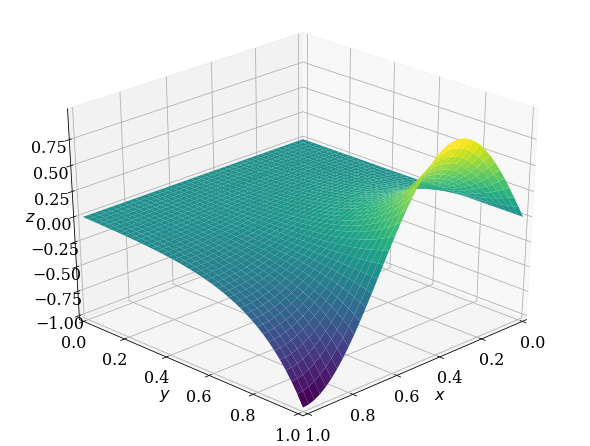

In [6]:
# Set parameters.
Lx, Ly = 1.0, 1.0  # lengths of the domain
nx, ny = 41, 41  # number of points along each direction

# Define grid-point locations.
x = np.linspace(0.0, Lx, num=nx)
y = np.linspace(0.0, Ly, num=ny)

analytical_sol = laplace_solution(x, y, Lx, Ly)
print(analytical_sol)
plot_3d(x, y, analytical_sol)

## Initial solution

<img src="figures/application_setup.png" alt="application_setup" width="300"/>

Initial guess: $u = 0$ everywhere inside the domain.

Boundary values:

* Bottom and left: $u = 0$
* Top: $u = \sin \left( \frac{3}{2} \pi \frac{x}{L_x} \right)$
* Right: $\frac{\partial u}{\partial x} = 0$

In [7]:
#initializing interior points
u0 = np.zeros_like(analytical_sol)
#u0.fill(2.0)

#initializing boundaries
u0[0,:] = 0.0
u0[:,0] = 0.0
u0[-1,:] = np.sin(1.5 * np.pi * x / Lx)
u0[:,-1] = u0[:,-2]

## Jacobi method

$$
u_{i, j}^{k+1} = \frac{1}{4} \left( u_{i, j-1}^k + u_{i-1, j}^k + u_{i+1, j}^k + u_{i, j+1}^k \right)
$$

In [8]:
def laplace_2d_jacobi(u0, maxiter=20000, rtol=1e-8):
    """Solve the 2D Laplace equation using Jacobi method.

    Parameters
    ----------
    u0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    u : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations computed.
    diff : float
        The final relative L2-norm of the difference.

    """
    u = u0.copy()  # create copy to not overwrite initial guess
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        un = u.copy()  # store the solution at previous iteration
        ite += 1  # update the iteration index
        ###
        # To do: Update the solution using Jacobi method.
        # To do: Update the value at boundaries (where necessary).
        # To do: Compute `diff`, the relative L2-norm of the difference
        # in the solution between two successive iterations.
        ###
        u[1:-1, 1:-1] = 0.25 * (un[1:-1,:-2] + un[:-2,1:-1] + un[2:,1:-1] + un[1:-1,2:])
        
        u[:,-1] = u[:,-2]
        
        diff = np.linalg.norm(u - un) / np.linalg.norm(un)

    return u, ite, diff

ITE:  4473
L2 norm:  9.98996953047594e-09
7257 9.990739825041801e-09


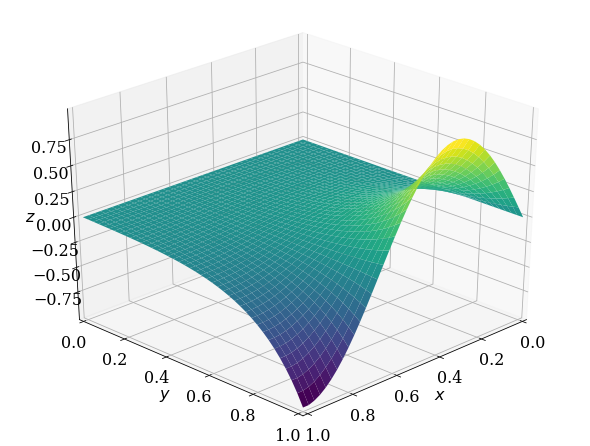

In [9]:
lap_sol, ite_out, diff_out = laplace_2d_jacobi(u0)

u0_2 = u0.copy()
u0_2[1:-1, 1:-1].fill(2.0)
lap_sol_2, ite_out_2, diff_out_2 = laplace_2d_jacobi(u0_2)

print("ITE: ", ite_out)
print("L2 norm: ", diff_out)
print(ite_out_2, diff_out_2)
plot_3d(x, y, lap_sol_2)


## Convergence analysis

In [28]:
# List of grid-spacing sizes to investigate.
dx_vals = [0.1, 0.05, 0.025, 0.0125]

# Empty list to store the error on each grid.
errors = []

for dx in dx_vals:
    ###
    # To do: Re-create the space grid.
    # To do: re-set the initial guess.
    # To do: Relax the solution with Jacobi.
    # To do: Compute the analytical solution.
    # To do: Compute and append the relative L2 error to `errors`.
    ###
    nx = 1 + int(Lx / dx)
    ny = nx
    x = np.linspace(0.0, Lx, num=nx)
    y = np.linspace(0.0, Ly, num=ny)
    
    #initial solution
    u0 = np.zeros((ny, nx))
    #initializing boundaries
    u0[0,:] = 0.0
    u0[:,0] = 0.0
    u0[-1,:] = np.sin(1.5 * np.pi * x / Lx)
    u0[:,-1] = u0[:,-2]
    
    lap_sol, ite_out, diff_out = laplace_2d_jacobi(u0)
    analytical_sol = laplace_solution(x, y, Lx, Ly)
    
    errors.append(np.linalg.norm(lap_sol - analytical_sol) / np.linalg.norm(analytical_sol))

Text(0.5, 1.0, 'Error between calculated and analytical solutions')

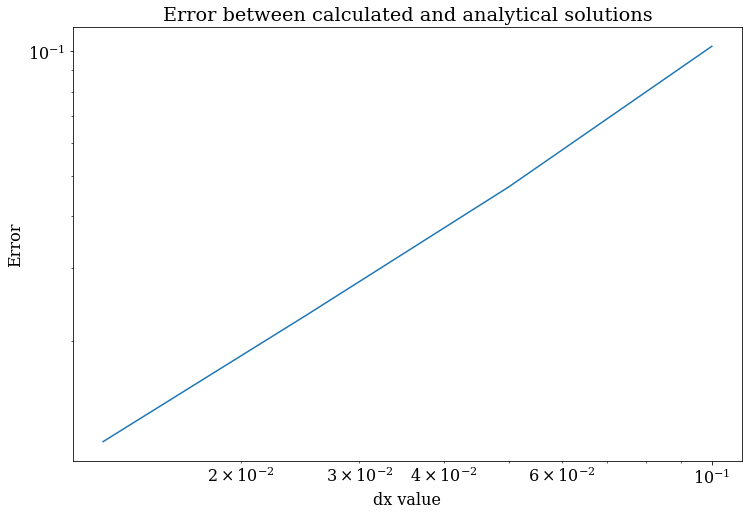

In [29]:
###
# To do: Plot (loglog) the error versus the grid-spacing size.
# Question: What's the order of convergence?
###

pyplot.figure(figsize=[12,8])
pyplot.plot(dx_vals, errors)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('dx value')
pyplot.ylabel('Error')
pyplot.title('Error between calculated and analytical solutions')

## 2nd-order Neumann boundary conditions

In [17]:
def laplace_2d_jacobi_neumann(u0, maxiter=20000, rtol=1e-8):
    """Solve the 2D Laplace equation using Jacobi method.

    Use a second-order approximation for Neumann boundary conditions.

    Parameters
    ----------
    u0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    u : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    diff : float
        The final relative L2-norm of the difference.

    """
    u = u0.copy()  # create copy to not overwrite initial guess
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        un = u.copy()  # store the solution at previous iteration
        ite += 1  # update the iteration index
        ###
        # To do: Update the solution using Jacobi method.
        # To do: Update the value at boundaries (where necessary).
        # To do: Compute `diff`, the relative L2-norm of the difference
        # in the solution between two successive iterations.
        ###
        
        u[1:-1, 1:-1] = 0.25 * (un[1:-1,:-2] + un[:-2,1:-1] + un[2:,1:-1] + un[1:-1,2:])
        
        u[1:-1,-1] = 0.25*(2*u[1:-1,-2] + u[:-2,-1] + u[2:,-1])
        
        diff = np.linalg.norm(u - un) / np.linalg.norm(un)
        
    return u, ite, diff

## Re-do convergence analysis

In [30]:
# List of grid-spacing sizes to investigate.
dx_vals_2 = [0.1, 0.05, 0.025, 0.0125]

# Empty list to store the error on each grid.
errors_2 = []

for dx in dx_vals_2:
    ###
    # To do: Re-create the space grid.
    # To do: re-set the initial guess.
    # To do: Relax the solution with Jacobi.
    # To do: Compute the analytical solution.
    # To do: Compute and append the relative L2 error to `errors`.
    ###
    nx = 1 + int(Lx / dx)
    ny = nx
    x = np.linspace(0.0, Lx, num=nx)
    y = np.linspace(0.0, Ly, num=ny)
    
    #initial solution
    u0 = np.zeros((ny, nx))
    #initializing boundaries
    u0[0,:] = 0.0
    u0[:,0] = 0.0
    u0[-1,:] = np.sin(1.5 * np.pi * x / Lx)
    u0[:,-1] = u0[:,-2]
    
    lap_sol_3, ite_out_3, diff_out_3 = laplace_2d_jacobi_neumann(u0)
    analytical_sol = laplace_solution(x, y, Lx, Ly)
    
    errors_2.append(np.linalg.norm(lap_sol_3 - analytical_sol) / np.linalg.norm(analytical_sol))

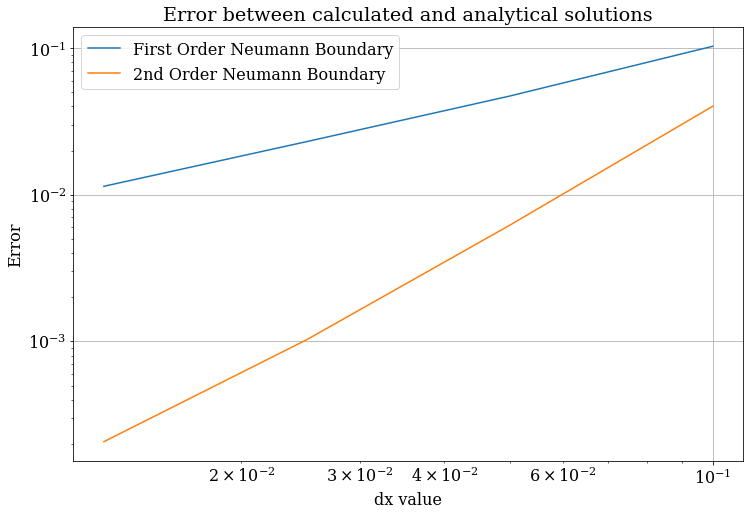

In [33]:
###
# To do: Plot (loglog) the error versus the grid-spacing size.
# Question: What's the order of convergence?
###
pyplot.figure(figsize=[12,8])
pyplot.plot(dx_vals, errors, label='First Order Neumann Boundary')
pyplot.plot(dx_vals_2, errors_2, label='2nd Order Neumann Boundary')
pyplot.legend(loc='best')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('dx value')
pyplot.ylabel('Error')
pyplot.grid()
pyplot.title('Error between calculated and analytical solutions');